In [1]:
# MODIFY! 
# use RobustScaler! 
model_name = 'rf-wo'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/d-wo-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

## Determine Max Features

In [6]:
# MODIFY!
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(warm_start=True)
model

RandomForestRegressor(warm_start=True)

In [7]:
p_grid = {
    'max_features':['auto', 'sqrt', 'log2']
}

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [10]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   27.0s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
grid_model.best_params_

{'max_features': 'auto'}

In [12]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [13]:
hp

max_features    auto
Name: rf-wo HP, dtype: object

In [14]:
hp.to_csv(f'./hyperparameters/{model_name}.csv')

## Determine Number of Estimators

In [15]:
# MODIFY!
import time

estimators = [5,10,25,50,100,500,1000,2000]
scores_list = []

from sklearn.ensemble import RandomForestRegressor

for e in estimators: 
    start = time.time()
    print(f'Starting {e} estimators')
    score_model = RandomForestRegressor(
        n_estimators=e,
        max_features=grid_model.best_params_['max_features']
    )
    
    from sklearn.model_selection import cross_validate

    scores = cross_validate(
        score_model, 
        X_train, 
        y_train,
        scoring=[
            'neg_mean_absolute_error',
            'neg_mean_squared_error',
            'neg_root_mean_squared_error'
        ],
        cv=10
    )
    
    scores = pd.DataFrame(scores)
    scores
    mean_scores = scores.mean()
    scores_list.append(mean_scores)
    print(f'Done with {e} estimators')
    end = time.time()
    print(f'Elapsed time: {end - start}')
    print('\n')

Starting 5 estimators
Done with 5 estimators
Elapsed time: 1.1123089790344238


Starting 10 estimators
Done with 10 estimators
Elapsed time: 2.145754098892212


Starting 25 estimators
Done with 25 estimators
Elapsed time: 4.612892150878906


Starting 50 estimators
Done with 50 estimators
Elapsed time: 9.08408808708191


Starting 100 estimators
Done with 100 estimators
Elapsed time: 18.024692058563232


Starting 500 estimators
Done with 500 estimators
Elapsed time: 127.84653425216675


Starting 1000 estimators
Done with 1000 estimators
Elapsed time: 222.815034866333


Starting 2000 estimators
Done with 2000 estimators
Elapsed time: 388.0314869880676




In [16]:
scores_df = pd.DataFrame(scores_list)

In [17]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.107624,0.002794,-3.311402,-21.016407,-4.573499
1,0.210628,0.003193,-3.230063,-19.910406,-4.449278
2,0.455510,0.004516,-3.096841,-18.383631,-4.272730
3,0.899361,0.007370,-3.057131,-18.085787,-4.239436
4,1.786931,0.013056,-3.057719,-17.936412,-4.220029
5,12.656635,0.113165,-3.042380,-17.840698,-4.208618
6,22.052606,0.202752,-3.033254,-17.763239,-4.199867
7,38.463426,0.293668,-3.030812,-17.745160,-4.197193


In [18]:
scores_df['Est'] = estimators

In [19]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,Est
0,0.107624,0.002794,-3.311402,-21.016407,-4.573499,5
1,0.210628,0.003193,-3.230063,-19.910406,-4.449278,10
2,0.455510,0.004516,-3.096841,-18.383631,-4.272730,25
3,0.899361,0.007370,-3.057131,-18.085787,-4.239436,50
4,1.786931,0.013056,-3.057719,-17.936412,-4.220029,100
5,12.656635,0.113165,-3.042380,-17.840698,-4.208618,500
6,22.052606,0.202752,-3.033254,-17.763239,-4.199867,1000
7,38.463426,0.293668,-3.030812,-17.745160,-4.197193,2000


# Export Scores for Number of Estimators

In [20]:
# mean_scores

In [21]:
scores_df = scores_df.rename(columns={
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [22]:
scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.107624,0.002794,-3.311402,-21.016407,-4.573499,5
1,0.210628,0.003193,-3.230063,-19.910406,-4.449278,10
2,0.455510,0.004516,-3.096841,-18.383631,-4.272730,25
3,0.899361,0.007370,-3.057131,-18.085787,-4.239436,50
4,1.786931,0.013056,-3.057719,-17.936412,-4.220029,100
5,12.656635,0.113165,-3.042380,-17.840698,-4.208618,500
6,22.052606,0.202752,-3.033254,-17.763239,-4.199867,1000
7,38.463426,0.293668,-3.030812,-17.745160,-4.197193,2000


In [23]:
scores_df[['MAE','MSE','RMSE']] = scores_df[['MAE','MSE','RMSE']].apply(lambda x : abs(x))

In [24]:
scores_df
# we go for 25 estimations. Note that from 25 -> 50 estimations the error metrics worsen

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.107624,0.002794,3.311402,21.016407,4.573499,5
1,0.210628,0.003193,3.230063,19.910406,4.449278,10
2,0.455510,0.004516,3.096841,18.383631,4.272730,25
3,0.899361,0.007370,3.057131,18.085787,4.239436,50
4,1.786931,0.013056,3.057719,17.936412,4.220029,100
5,12.656635,0.113165,3.042380,17.840698,4.208618,500
6,22.052606,0.202752,3.033254,17.763239,4.199867,1000
7,38.463426,0.293668,3.030812,17.745160,4.197193,2000


In [25]:
scores_df.to_csv(f'./est-scores/{model_name}-est.csv')

In [26]:
pct_scores_df = scores_df.pct_change()

In [27]:
pct_scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.957074,0.142995,-0.024563,-0.052626,-0.027161,1.0
2,1.162624,0.414343,-0.041244,-0.076682,-0.039680,1.5
3,0.974405,0.631838,-0.012823,-0.016202,-0.007792,1.0
4,0.986891,0.771518,0.000192,-0.008259,-0.004578,1.0
5,6.082889,7.667654,-0.005016,-0.005336,-0.002704,4.0
6,0.742375,0.791648,-0.002999,-0.004342,-0.002079,1.0
7,0.744167,0.448410,-0.000805,-0.001018,-0.000637,1.0


In [28]:
pct_scores_df.style.background_gradient() 
# we choose index 4, 100 Estimations <- 
    # Score time decrease 3->4 & Score time increase dramatically 4->5
    # unsubstantial decrease MSE & RMSE 4->5 compared to 3->4

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,nan,nan,nan,nan,nan,nan
1,0.957074,0.142995,-0.024563,-0.052626,-0.027161,1.000000
2,1.162624,0.414343,-0.041244,-0.076682,-0.039680,1.500000
3,0.974405,0.631838,-0.012823,-0.016202,-0.007792,1.000000
4,0.986891,0.771518,0.000192,-0.008259,-0.004578,1.000000
5,6.082889,7.667654,-0.005016,-0.005336,-0.002704,4.000000
6,0.742375,0.791648,-0.002999,-0.004342,-0.002079,1.000000
7,0.744167,0.448410,-0.000805,-0.001018,-0.000637,1.000000


# Score Model

In [29]:
# MODIFY!
# adopt number of estimators from the previous section

score_model = RandomForestRegressor(n_estimators=100,warm_start=True)
score_model

RandomForestRegressor(warm_start=True)

In [30]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [31]:
scores = pd.DataFrame(scores)

In [32]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,2.332699,0.013970,-3.025310,-15.496049,-3.936502
1,2.195743,0.025364,-2.974305,-16.885003,-4.109136
2,1.975829,0.013406,-2.932213,-15.353194,-3.918315
3,2.023836,0.013144,-3.286877,-22.753494,-4.770062
4,3.229563,0.013693,-3.256563,-23.349320,-4.832113
5,1.977622,0.012794,-3.036775,-18.691656,-4.323385
6,2.085626,0.019308,-2.667424,-12.410283,-3.522823
7,1.924015,0.012637,-3.066960,-17.427979,-4.174683
8,1.976282,0.017500,-3.093711,-17.116046,-4.137154
9,2.713884,0.013704,-3.173564,-19.085259,-4.368668


In [33]:
mean_scores = scores.mean()

In [34]:
mean_scores

fit_time                             2.243510
score_time                           0.015552
test_neg_mean_absolute_error        -3.051370
test_neg_mean_squared_error        -17.856828
test_neg_root_mean_squared_error    -4.209284
dtype: float64

# Export Model Scores

In [35]:
mean_scores = mean_scores.rename(f'{model_name}')

In [36]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [37]:
# mean_scores

In [38]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [39]:
mean_scores

Fit Time       2.243510
Score Time     0.015552
MAE            3.051370
MSE           17.856828
RMSE           4.209284
Name: rf-wo, dtype: float64

In [40]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [41]:
mean_scores

Fit Time       2.243510
Score Time     0.015552
MAE            3.051370
MSE           17.856828
RMSE           4.209284
STD FT         0.420689
STD ST         0.004083
STD MAE        0.177319
STD MSE        3.325561
STD RMSE       0.392647
Name: rf-wo, dtype: float64

In [42]:
mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [43]:
score_model.fit(X_train,y_train)

RandomForestRegressor(warm_start=True)

In [44]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

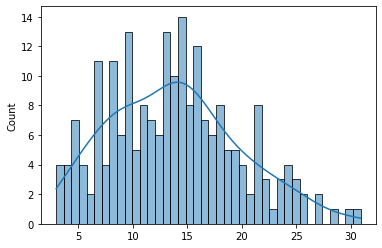

In [45]:
sns.histplot(y_holdout,bins=40,kde=True)

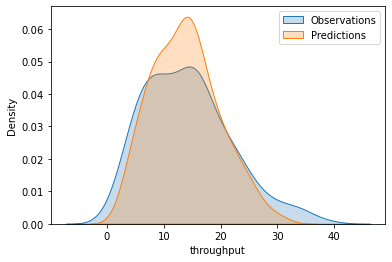

In [46]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

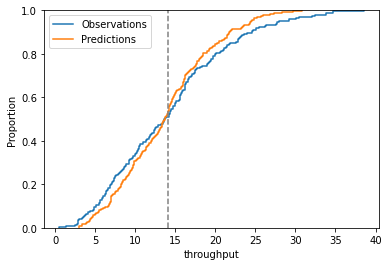

In [47]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [49]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-wo
MAE,3.363837
MSE,21.058934
RMSE,4.589001


In [50]:
err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [51]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.350125
std      4.586303
min    -10.781164
25%     -2.290987
50%     -0.261479
75%      2.575492
max     18.821622
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

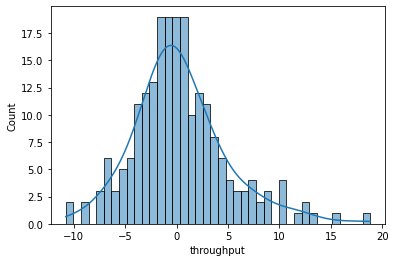

In [52]:
sns.histplot(data=res, kde=True,bins=40)

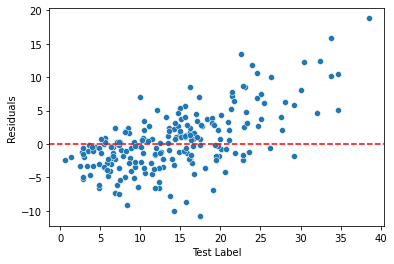

In [53]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

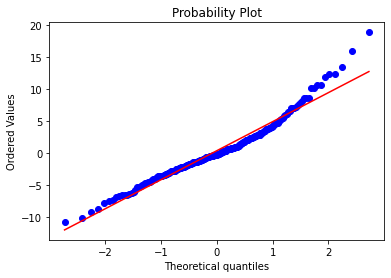

In [54]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [55]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [56]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

/Users/aceituno/opt/anaconda3/envs/masterclass/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


RandomForestRegressor(warm_start=True)

In [57]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

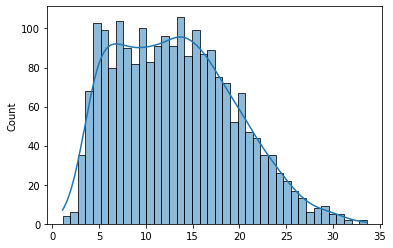

In [58]:
sns.histplot(y_pred,bins=40,kde=True)

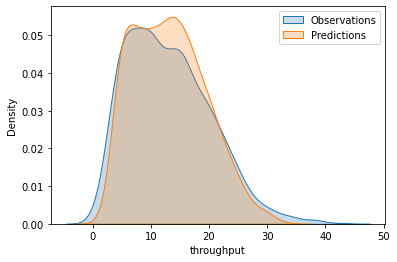

In [59]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

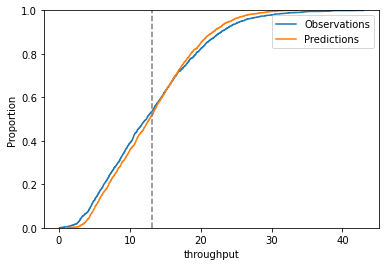

In [60]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [61]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [62]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,rf-wo
MAE,1.557244
MSE,5.541898
RMSE,2.354124


In [63]:
err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [64]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}.joblib')

['./opt-models/rf-wo.joblib']

In [65]:
res = y - y_pred
res.describe().drop('count')

mean    -0.014418
std      2.354629
min    -11.322524
25%     -1.096975
50%     -0.148874
75%      0.923218
max     18.978575
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

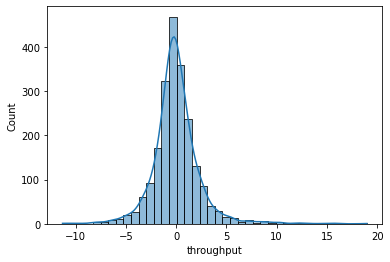

In [66]:
sns.histplot(data=res, kde=True,bins=40)

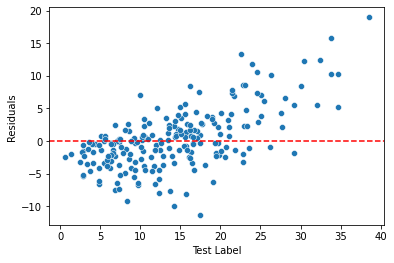

In [67]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

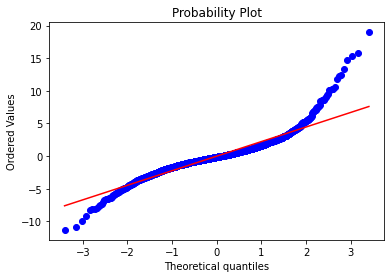

In [68]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!